In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from mat6115.hidden import run_and_save_hidden, get_hidden
from mat6115.dataset import dataset_factory, TEXT, LABEL, SEED
from mat6115.model import RNN
from mat6115.train import custom_loss, acc
from poutyne.framework import Model
import torch
from torch import nn
from pathlib import Path
import pickle

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [2]:
train_iter, valid_iter, test_iter = dataset_factory("imdb", embedding="glove.6B.100d")

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

SAVE_PATH = Path('rnn')
kwargs = dict(
    vocab_size = len(TEXT.vocab),
    embedding_dim = 100,
    hidden_dim = 256,
    output_dim = 1,
    n_layers = 1,
    bidirectional = False,
    dropout = 0.5,
    pad_idx = TEXT.vocab.stoi[TEXT.pad_token],
    rnn_type = 'lstm'
)

vanilla_network=RNN(**kwargs)
trained_network=RNN(**kwargs)

vanilla = Model(
    network=vanilla_network, 
    optimizer=torch.optim.Adam(vanilla_network.parameters()), 
    loss_function=custom_loss,
    batch_metrics=[acc]
)
trained = Model(
    network=trained_network, 
    optimizer=torch.optim.Adam(trained_network.parameters()), 
    loss_function=custom_loss,
    batch_metrics=[acc]
)
trained.load_weights(SAVE_PATH / 'model.pkl')

vanilla.to(device)
trained.to(device)

In [4]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    prediction = model.predict((tensor, length_tensor), batch_size=1)
    return 1 * LABEL.vocab.stoi['neg'] - 1 / (1 + np.exp(-prediction[0]))

In [5]:
predict_sentiment(trained, "This film is terrible")

array([0.14414859], dtype=float32)

In [6]:
predict_sentiment(vanilla, "This film is terrible")

array([0.4881441], dtype=float32)

In [58]:
vanilla_hidden_states, vanilla_preds, vanilla_ground_truth = get_hidden(
    vanilla, test_iter, N=5000
)
trained_hidden_states, trained_preds, trained_ground_truth = get_hidden(
    trained, test_iter, N=5000
)

In [59]:
pca_vanilla = PCA()
pca_trained = PCA()

pca_vanilla.fit(vanilla_hidden_states)
pca_trained.fit(trained_hidden_states)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [60]:
plt.scatter(
    np.arange(len(pca_vanilla.explained_variance_ratio_)),
    pca_vanilla.explained_variance_ratio_.cumsum(),
    s=2,
    c="#D9D9D9"
)
plt.scatter(
    np.arange(len(pca_trained.explained_variance_ratio_)),
    pca_trained.explained_variance_ratio_.cumsum(),
    s=2,
    c="#282828"
)

In [61]:
pca_vanilla_2 = PCA(n_components=2)
pca_trained_2 = PCA(n_components=2)

vanilla_data = pca_vanilla_2.fit_transform(vanilla_hidden_states)
trained_data = pca_trained_2.fit_transform(trained_hidden_states)

<IPython.core.display.Javascript object>


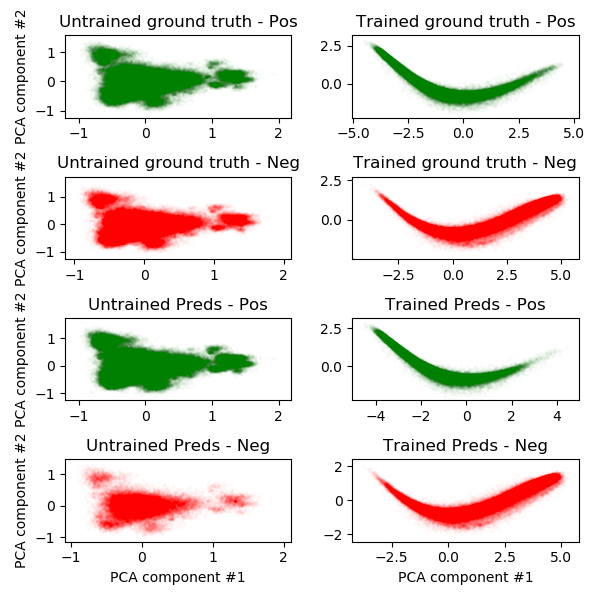

In [63]:
fig, ax = plt.subplots(4, 2, figsize=(6, 6))
pos_idx = vanilla_ground_truth == LABEL.vocab.stoi['pos']
neg_idx = vanilla_ground_truth == LABEL.vocab.stoi['neg']
ax[0][0].scatter(vanilla_data[pos_idx, 0], vanilla_data[pos_idx, 1], c='g', alpha=0.009, s=2)
ax[0][0].set_title('Untrained ground truth - Pos')
ax[0][0].set_ylabel("PCA component #2")

ax[1][0].scatter(vanilla_data[neg_idx, 0], vanilla_data[neg_idx, 1], c='r', alpha=0.009, s=2)
ax[1][0].set_title('Untrained ground truth - Neg')
ax[1][0].set_ylabel("PCA component #2")

pos_idx = trained_ground_truth == LABEL.vocab.stoi['pos']
neg_idx = trained_ground_truth == LABEL.vocab.stoi['neg']
ax[0][1].scatter(trained_data[pos_idx, 0], trained_data[pos_idx, 1], c='g', alpha=0.009, s=2)
ax[0][1].set_title('Trained ground truth - Pos')

ax[1][1].scatter(trained_data[neg_idx, 0], trained_data[neg_idx, 1], c='r', alpha=0.009, s=2)
ax[1][1].set_title('Trained ground truth - Neg')

pos_idx = vanilla_preds == LABEL.vocab.stoi['pos']
neg_idx = vanilla_preds == LABEL.vocab.stoi['neg']
ax[2][0].scatter(vanilla_data[pos_idx, 0], vanilla_data[pos_idx, 1], c='g', alpha=0.009, s=2)
ax[2][0].set_title('Untrained Preds - Pos')
ax[2][0].set_ylabel("PCA component #2")

ax[3][0].scatter(vanilla_data[neg_idx, 0], vanilla_data[neg_idx, 1], c='r', alpha=0.009, s=2)
ax[3][0].set_title('Untrained Preds - Neg')
ax[3][0].set_xlabel("PCA component #1")
ax[3][0].set_ylabel("PCA component #2")

pos_idx = trained_preds == LABEL.vocab.stoi['pos']
neg_idx = trained_preds == LABEL.vocab.stoi['neg']
ax[2][1].scatter(trained_data[pos_idx, 0], trained_data[pos_idx, 1], c='g', alpha=0.009, s=2)
ax[2][1].set_title('Trained Preds - Pos')

ax[3][1].scatter(trained_data[neg_idx, 0], trained_data[neg_idx, 1], c='r', alpha=0.009, s=2)
ax[3][1].set_title('Trained Preds - Neg')
ax[3][1].set_xlabel("PCA component #1")
plt.tight_layout()

In [67]:

pca_trained_3 = PCA(n_components=3)

trained_data_3 = pca_trained_3.fit_transform(trained_hidden_states)

<IPython.core.display.Javascript object>


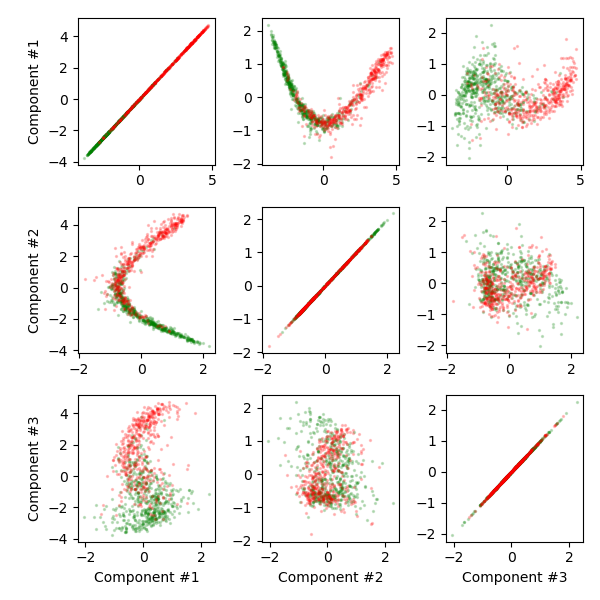

(3, 3)


In [72]:
from itertools import product

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
random_idx = np.arange(len(trained_data_3))
np.random.shuffle(random_idx)
random_idx = random_idx[:1000]

pos_idx = vanilla_ground_truth[random_idx] == LABEL.vocab.stoi['pos']
neg_idx = vanilla_ground_truth[random_idx] == LABEL.vocab.stoi['neg']
print(ax.shape)

for i, j in product([0,1,2], [0,1,2]):
    ax[i][j].scatter(
        trained_data_3[random_idx][pos_idx, i], 
        trained_data_3[random_idx][pos_idx, j], 
        c='g', alpha=0.2, s=2
    )
    ax[i][j].scatter(
        trained_data_3[random_idx][neg_idx, i], 
        trained_data_3[random_idx][neg_idx, j], 
        c='r', alpha=0.2, s=2
    )
    if j == 0:
        ax[i][j].set_ylabel(f"Component #{i+1}")
    if i == 2:
        ax[i][j].set_xlabel(f"Component #{j+1}")



plt.tight_layout()

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

In [74]:

pca_trained_3 = PCA(n_components=3)

trained_data_3 = pca_trained_3.fit_transform(trained_hidden_states)

<IPython.core.display.Javascript object>


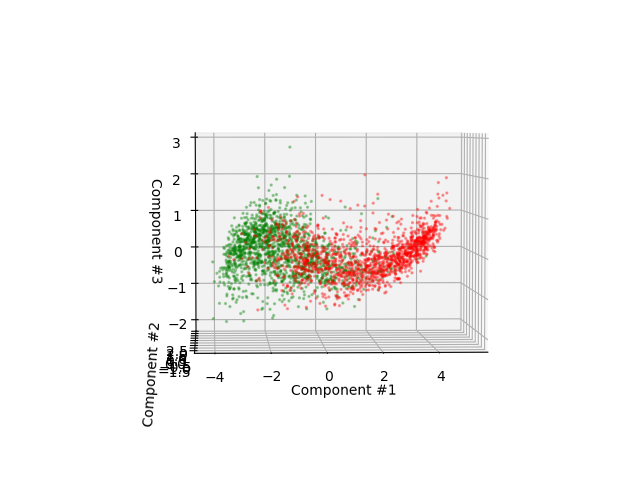

Text(0.5, 0, 'Component #3')

In [75]:
# Plot trajectory
fig = plt.figure()
ax = plt.axes(projection='3d')
random_idx = np.arange(len(trained_data_3))
np.random.shuffle(random_idx)
random_idx = random_idx[:3000]

pos_idx = trained_ground_truth[random_idx] == LABEL.vocab.stoi['pos']
neg_idx = trained_ground_truth[random_idx] == LABEL.vocab.stoi['neg']

ax.scatter3D(
    trained_data_3[random_idx][pos_idx,0],
    trained_data_3[random_idx][pos_idx,1],
    trained_data_3[random_idx][pos_idx,2],
    c='g', s=2, alpha=0.3
)

ax.scatter3D(
    trained_data_3[random_idx][neg_idx,0],
    trained_data_3[random_idx][neg_idx,1],
    trained_data_3[random_idx][neg_idx,2],
    c='r', s=2, alpha=0.3
)

ax.set_xlabel('Component #1')
ax.set_ylabel('Component #2')
ax.set_zlabel('Component #3')

In [53]:
trained_data_3[random_idx][pos_idx,2].shape

(496,)